<a href="https://colab.research.google.com/github/kjedrzejczak/Wprowadzenie_do_sieci_neuronowych-Tensorflow_2.0-Keras/blob/main/22_Przygotowanie_zdj%C4%99%C4%87_do_modelu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

In [2]:
# !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
# !unzip -q flying-vehicles.zip

# Przygotowanie danych

In [3]:
!rm -rf ./images  # czyszczenie katalogu roboczego

In [4]:
"""👉Sprawdzanie ilości zdjęc dla danej klasy👈"""
base_dir = './data/planes'
row_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for i in classes:
  row_no_of_files[i] = len(os.listdir(os.path.join(base_dir, i)))


row_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
"""👉tworzymy katalog "images" -> "train" -> ['drone', 'passenger']👈"""

data_dir = './images'

if not os.path.exists(data_dir):   # katalog główny "images"
  os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')   # podkatalog dane treningowe
valid_dir = os.path.join(data_dir, 'valid')   # podkatalog dane treningowe
test_dir = os.path.join(data_dir, 'test')     # podkatalog dane treningowe


train_drone_dir = os.path.join(train_dir, 'drone')
valid_drone_dir = os.path.join(valid_dir, 'drone')
test_drone_dir = os.path.join(test_dir, 'drone')


train_passenger_dir = os.path.join(train_dir, 'passenger')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')
test_passenger_dir = os.path.join(test_dir, 'passenger')

"""tworzenie katalogów"""
for i in (train_dir, valid_dir, test_dir):
  if not os.path.exists(i):
    os.mkdir(i)


dirs = [train_drone_dir, valid_drone_dir, test_drone_dir,      train_passenger_dir, valid_passenger_dir, test_passenger_dir]

for i in dirs:
  if not os.path.exists(i):
    os.mkdir(i)


In [6]:
""" pobieramy nazwy plików """

base_dir = './data/planes'

drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))               # lista nazw plików a katalogu dron
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane')) # lista nazw plików a katalogu passenger-plain


drone_fnames = [i for i in drone_fnames if i.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]         # ograniczenie do formatów jpg, png, jpeg - dzielimy nazwę po kropce 👈
passenger_fnames = [i for i in passenger_fnames if i.split('.')[1].lower() in ['jpg', 'png', 'jpeg']] # ograniczenie do formatów jpg, png, jpeg

In [7]:
"""określenie ilości danych potrzebych do budowy modelu"""

size = min(len(drone_fnames), len(passenger_fnames)) # wybieramy min z dwóch klas

train_size = int(np.floor(0.7 * size))  # floor użyty żeby nie pojawił się błąd indeksu (lepiej mniej niż więcej)
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size   # tworzymy indeksy do kopiowania plików
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

print(train_idx)
print(valid_idx)
print(test_idx)

918
1180
1312


In [8]:
"""👉kopiowanie plików👈"""

for i, fname in enumerate(drone_fnames):  # i -> idx wartość
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


# Przegląd danych

(-0.5, 1279.5, 719.5, -0.5)

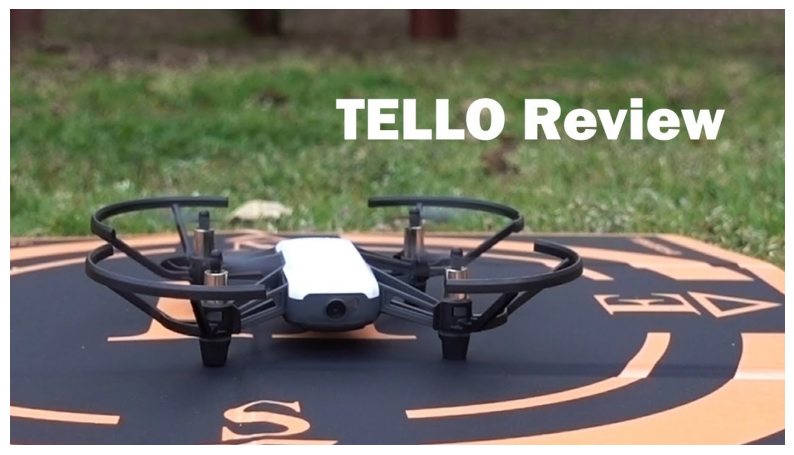

In [9]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 380 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 779.5, 512.5, -0.5)

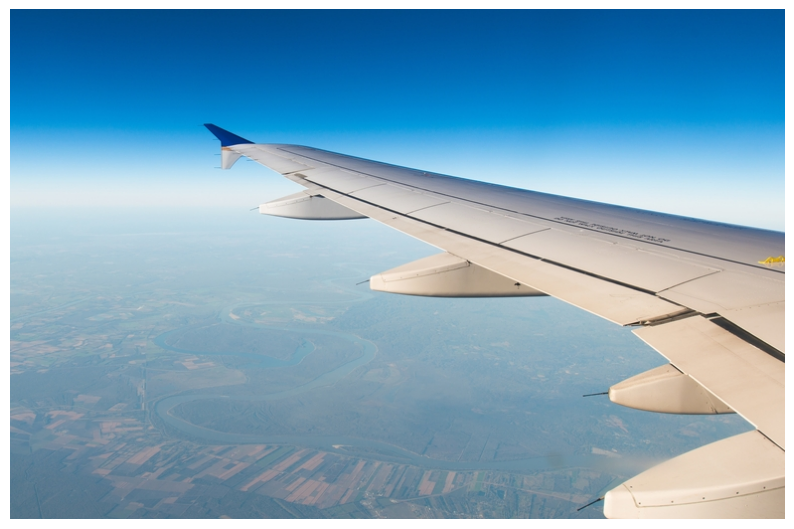

In [10]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 699 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

# Augmentacja danych

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)                           # generator można po nim iterować 👈👈👈👈

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)  # tlko przekształcenie do 0 - 1 wartości na zbiorze validacyjnym 👈👈👈👈

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')  # łądujemny bezpośrednio z katalogu
                                                                         # różne rozmiary zdjęć więc standaryzacja rozmiaru "target size"
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [12]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)] # generuje scieżki do plików 👈👈👈👈
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)  # przekształcanie do tablicy numpy
    print(x.shape)
    x = x.reshape((1, ) + x.shape) # dodawanie jednego wymiaru
    print(x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for k in train_datagen.flow(x, batch_size=1):  # generator można po nim iterować 👈👈👈👈
        plt.subplot(3, 4, i)
        plt.grid(False)
        plt.imshow(image.array_to_img(k[0]))
        i += 1
        if i % 13 == 0:
            break

(150, 150, 3)
(1, 150, 150, 3)


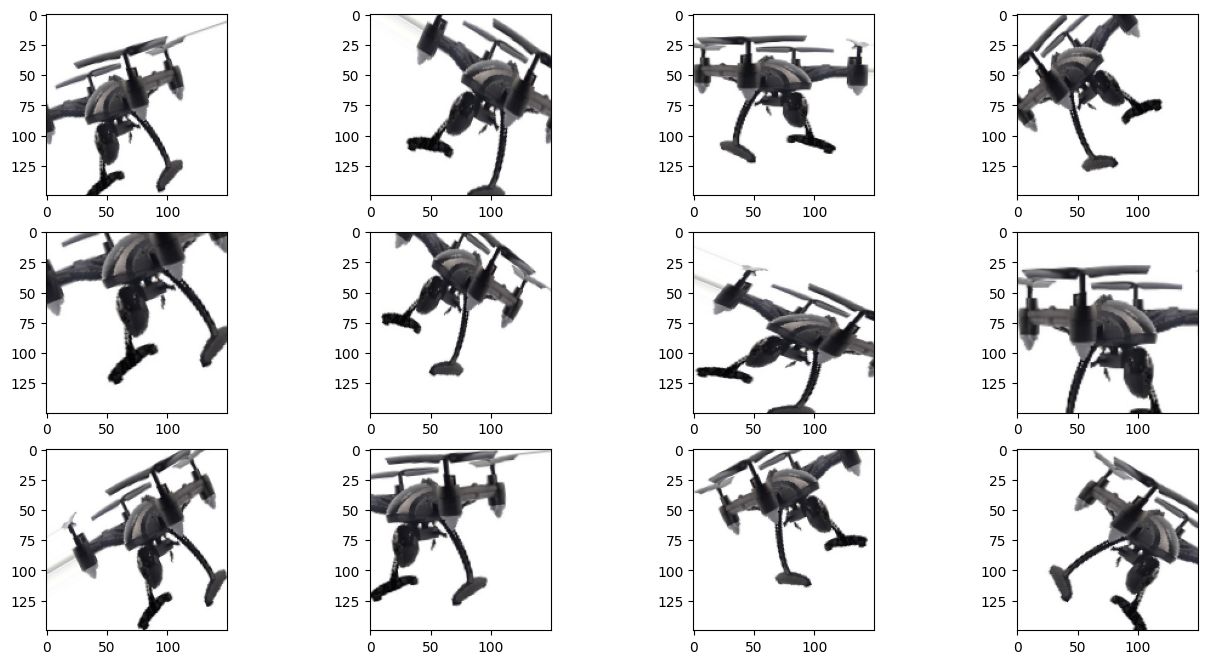

In [13]:
#@title Zbiór treningowy drone:
idx = 189 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

(150, 150, 3)
(1, 150, 150, 3)


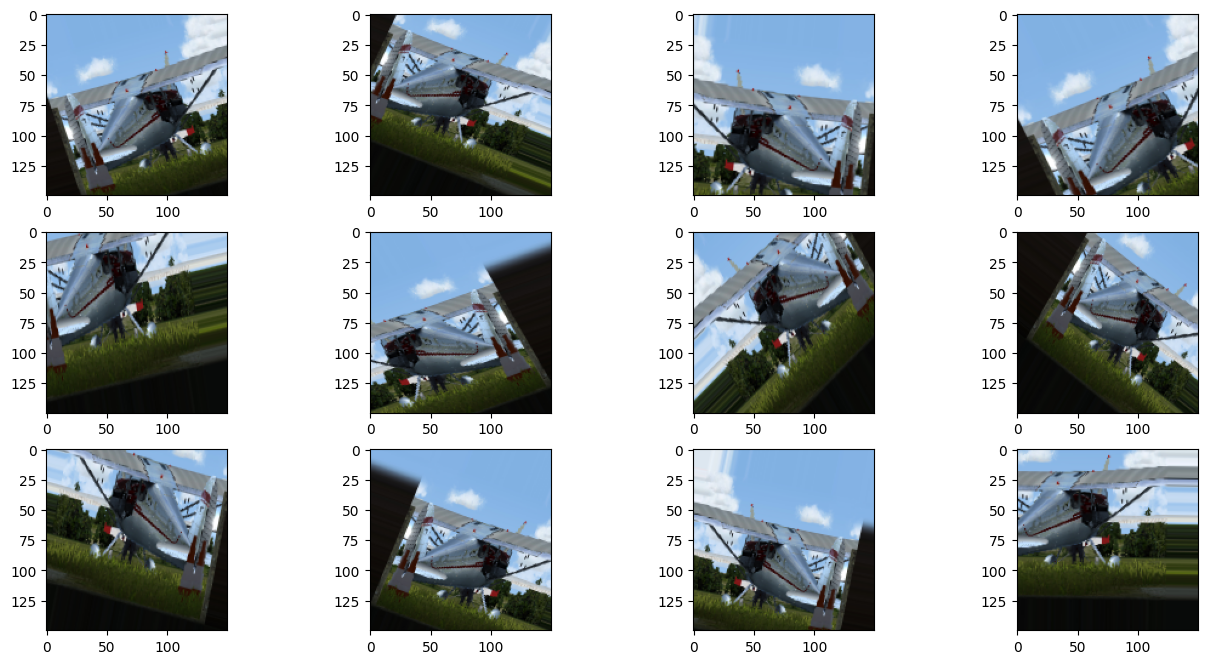

In [14]:
#@title Zbiór treningowy passenger:
idx = 111 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

# Budowa modelu